In [180]:
import statsmodels.api as sm #for OLS regression
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt #for heatmap plotting
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns #for heatmap plotting
from statsmodels.iolib.summary2 import summary_col #to summarize multiple regressions in one table
from datetime import date
from dateutil.relativedelta import relativedelta
import math
from scipy import stats
import time
from tqdm import tqdm
from itertools import product
import multiprocessing

In [2]:
####################  1. Regression with Daily Return   ###################################

### data

In [3]:
#pf_size = pd.read_csv('C:/Users/yz2991/Desktop/Portfolios_Formed_on_ME_daily.csv')
#ff5 = pd.read_csv('C:/Users/yz2991/Desktop/F-F_Research_Data_5_Factors_2x3_daily.csv')
pf_size = pd.read_csv('data/Portfolios_Formed_on_ME_daily.csv')
ff5 = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3_daily.csv')

In [4]:
pf_size.head()

,Unnamed: 0,<= 0,Lo 30,Med 40,Hi 30,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,2-Dec,3-Dec,4-Dec,5-Dec,6-Dec,7-Dec,8-Dec,9-Dec,Hi 10
0,19630701.0,-99.99,-0.58,-0.54,-0.67,-0.61,-0.69,-0.47,-0.56,-0.68,-0.64,-0.58,-0.54,-0.81,-0.55,-0.41,-0.52,-0.59,-0.69,-0.68
1,19630702.0,-99.99,0.44,0.59,0.85,0.50,0.62,0.54,0.72,0.85,0.38,0.62,0.33,0.86,0.50,0.56,0.55,0.82,0.65,0.89
2,19630703.0,-99.99,0.55,0.58,0.65,0.52,0.57,0.62,0.62,0.65,0.41,0.63,0.61,0.54,0.40,0.78,0.56,0.66,0.63,0.65
3,19630705.0,-99.99,0.33,0.34,0.43,0.41,0.29,0.37,0.29,0.44,0.36,0.48,0.18,0.39,0.41,0.34,0.29,0.29,0.31,0.47
4,19630708.0,-99.99,-0.43,-0.53,-0.63,-0.35,-0.74,-0.62,-0.36,-0.66,-0.47,-0.22,-0.58,-0.86,-0.64,-0.60,-0.30,-0.39,-0.47,-0.70


In [5]:
ff5.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.00,-0.32,-0.01,0.15,0.012
1,19630702,0.79,-0.27,0.27,-0.07,-0.19,0.012
2,19630703,0.63,-0.17,-0.09,0.17,-0.33,0.012
3,19630705,0.40,0.08,-0.28,0.08,-0.33,0.012
4,19630708,-0.63,0.04,-0.18,-0.29,0.13,0.012


In [6]:
pf_size.rename(columns = {'Unnamed: 0': 'YYMM'}, inplace = True)
ff5.rename(columns = {'Unnamed: 0': 'YYMM'}, inplace = True)

In [7]:
pf_size_excess=(pf_size.iloc[:,1:pf_size.shape[1]]).sub(ff5.RF,axis=0)
print(pf_size_excess.head())

      <= 0  Lo 30  Med 40  Hi 30  Lo 20  Qnt 2  Qnt 3  Qnt 4  Hi 20  Lo 10  \
0 -100.002 -0.592  -0.552 -0.682 -0.622 -0.702 -0.482 -0.572 -0.692 -0.652   
1 -100.002  0.428   0.578  0.838  0.488  0.608  0.528  0.708  0.838  0.368   
2 -100.002  0.538   0.568  0.638  0.508  0.558  0.608  0.608  0.638  0.398   
3 -100.002  0.318   0.328  0.418  0.398  0.278  0.358  0.278  0.428  0.348   
4 -100.002 -0.442  -0.542 -0.642 -0.362 -0.752 -0.632 -0.372 -0.672 -0.482   

   2-Dec  3-Dec  4-Dec  5-Dec  6-Dec  7-Dec  8-Dec  9-Dec  Hi 10  
0 -0.592 -0.552 -0.822 -0.562 -0.422 -0.532 -0.602 -0.702 -0.692  
1  0.608  0.318  0.848  0.488  0.548  0.538  0.808  0.638  0.878  
2  0.618  0.598  0.528  0.388  0.768  0.548  0.648  0.618  0.638  
3  0.468  0.168  0.378  0.398  0.328  0.278  0.278  0.298  0.458  
4 -0.232 -0.592 -0.872 -0.652 -0.612 -0.312 -0.402 -0.482 -0.712  


In [8]:
ff5['YYMM'] = pd.to_datetime(ff5['YYMM'],yearfirst=True, format='%Y%m%d')
pf_size_excess['YYMM'] = pd.to_datetime(pf_size['YYMM'],yearfirst=True, format='%Y%m%d')
print(pf_size_excess.head())

      <= 0  Lo 30  Med 40  Hi 30  Lo 20  Qnt 2  Qnt 3  Qnt 4  Hi 20  Lo 10  \
0 -100.002 -0.592  -0.552 -0.682 -0.622 -0.702 -0.482 -0.572 -0.692 -0.652   
1 -100.002  0.428   0.578  0.838  0.488  0.608  0.528  0.708  0.838  0.368   
2 -100.002  0.538   0.568  0.638  0.508  0.558  0.608  0.608  0.638  0.398   
3 -100.002  0.318   0.328  0.418  0.398  0.278  0.358  0.278  0.428  0.348   
4 -100.002 -0.442  -0.542 -0.642 -0.362 -0.752 -0.632 -0.372 -0.672 -0.482   

   2-Dec  3-Dec  4-Dec  5-Dec  6-Dec  7-Dec  8-Dec  9-Dec  Hi 10       YYMM  
0 -0.592 -0.552 -0.822 -0.562 -0.422 -0.532 -0.602 -0.702 -0.692 1963-07-01  
1  0.608  0.318  0.848  0.488  0.548  0.538  0.808  0.638  0.878 1963-07-02  
2  0.618  0.598  0.528  0.388  0.768  0.548  0.648  0.618  0.638 1963-07-03  
3  0.468  0.168  0.378  0.398  0.328  0.278  0.278  0.298  0.458 1963-07-05  
4 -0.232 -0.592 -0.872 -0.652 -0.612 -0.312 -0.402 -0.482 -0.712 1963-07-08  


In [9]:
ff5.index = ff5['YYMM']
pf_size_excess.index = pf_size_excess['YYMM']
ff5 = ff5.drop('YYMM', axis = 1)
ff5 = ff5.drop('RF', axis = 1)
# pf_size_excess = pf_size_excess.loc[:,['Lo 30','Med 40','Hi 30']]

In [10]:
print(ff5.head())

            Mkt-RF   SMB   HML   RMW   CMA
YYMM                                      
1963-07-01   -0.67  0.00 -0.32 -0.01  0.15
1963-07-02    0.79 -0.27  0.27 -0.07 -0.19
1963-07-03    0.63 -0.17 -0.09  0.17 -0.33
1963-07-05    0.40  0.08 -0.28  0.08 -0.33
1963-07-08   -0.63  0.04 -0.18 -0.29  0.13


### moving window

In [11]:
start = ff5.index[0]
end = ff5.index[-1]
n_day = end - start

In [12]:
ff5.index[-1]

Timestamp('2019-05-31 00:00:00')

In [166]:
print(n_day.days)
print(ff5.shape)
#because there are weekends and public holidays, we use every 126 records as a proxy of every 6-month window\n",
#There are in total 14075 records, thus will have 14075 - 126 + 1 =  13950 windows\n",
window = 126
n_window = ff5.shape[0] - 126 + 1
print(n_window)

20423
(14075, 5)
13950


In [14]:
#To run OLS on a 6-month rolling window basis. The logic of this loop is to run the rolling window regressions \n",
#for each of the 3 portfolios. That is, the first 13950 models are for the portfolio Lo 30,\n",
#the next 13950 models are for the portfolio Med 40\n",
pf_3 = pf_size_excess.loc[:,['Lo 30','Med 40','Hi 30']]
pf_3.head()

,Lo 30,Med 40,Hi 30
YYMM,,,
1963-07-01,-0.592,-0.552,-0.682
1963-07-02,0.428,0.578,0.838
1963-07-03,0.538,0.568,0.638
1963-07-05,0.318,0.328,0.418
1963-07-08,-0.442,-0.542,-0.642


In [157]:
pf_size_excess_3_5_10 = pf_size_excess.iloc[:-4,1:-1]

In [158]:
ff5.shape

(14075, 5)

In [159]:
pf_size_excess_3_5_10.shape

(14075, 18)

In [160]:
ff5.index

DatetimeIndex(['1963-07-01', '1963-07-02', '1963-07-03', '1963-07-05',
               '1963-07-08', '1963-07-09', '1963-07-10', '1963-07-11',
               '1963-07-12', '1963-07-15',
               ...
               '2019-05-17', '2019-05-20', '2019-05-21', '2019-05-22',
               '2019-05-23', '2019-05-24', '2019-05-28', '2019-05-29',
               '2019-05-30', '2019-05-31'],
              dtype='datetime64[ns]', name='YYMM', length=14075, freq=None)

In [162]:
start_dates = []
targets = list(pf_size_excess_3_5_10.columns)
targets

['Lo 30',
 'Med 40',
 'Hi 30',
 'Lo 20',
 'Qnt 2',
 'Qnt 3',
 'Qnt 4',
 'Hi 20',
 'Lo 10',
 '2-Dec',
 '3-Dec',
 '4-Dec',
 '5-Dec',
 '6-Dec',
 '7-Dec',
 '8-Dec',
 '9-Dec',
 'Hi 10']

In [152]:
start_idx=0
print(start_idx+window-1)

In [ ]:
ff5.iloc[0:125,:]

In [ ]:
ff5.iloc[start_idx: start_idx+window-1, :]

In [167]:
def reg_i(start_idx, target):
    window_size = 126
    x = ff5.iloc[start_idx: start_idx+window-1, :]
    y = pf_size_excess_3_5_10.iloc[start_idx: start_idx+window-1, [target]]
    reg = sm.OLS(y, x)   
    return reg.fit()

In [15]:
import multiprocessing
from itertools import product

def merge_names(a, b):
    return '{} & {}'.format(a, b)


targets = list(pf_size_excess_3_5_10.columns)
indices = range(n_window-window)

In [ ]:
res_dict = {}
with multiprocessing.Pool() as pool:
    args_ = product(indices, targets)
    for idx, ret in enumerate(pool.starmap(reg_i, args_)):
        res_dict[args[idx]] = ret

In [173]:
targets = list(pf_size_excess_3_5_10.columns)
indices = range(n_window-window)
a= product(indices, targets)

In [15]:
start_ = time.time()

In [ ]:
models_3_pf = []
for i in range (3):
    print('part {}/3'.format(i+1))
    for m in tqdm(range(n_window)):
        
        t0 = ff5.index[0+m]
        if ff5.index[0+m+window-1] < end:
            t1 = ff5.index[0+m+window-1]
        else:
            t1 = end
        
        x = ff5[t0:t1]
        x = sm.add_constant(x)
        y = pf_3[t0:t1]
        reg = sm.OLS(y.iloc[:,i], x)   
        models_3_pf.append(reg.fit())
print(time.time()-start_)

In [16]:
reg = sm.OLS(pf_3.iloc[:2000,0], sm.add_constant(ff5.iloc[:2000])) 

In [178]:
reg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Hi 10   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3378.
Date:                Fri, 12 Jul 2019   Prob (F-statistic):          4.22e-122
Time:                        17:52:15   Log-Likelihood:                -22.575
No. Observations:                 120   AIC:                             57.15
Df Residuals:                     114   BIC:                             73.88
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0212      0.029     -0.721      0.472      -0.079       0.037
Mkt-RF         0.9922      0.008    122.715      0.000       0.976       1.008
SMB           -0.2183      0.013    -16.562      0.000      -0.244      -0.192
HML           -0.0022      0.016     -0.137      0.892      -0.034       0.029
RMW            0.0268      0.020      1.314      0.192      -0.014       0.067
CMA           -0.0122      0.025     -0.490      0.625      -0.061       0.037
==============================================================================
Omnibus:                        9.160   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.061
Skew:                           0.648   Prob(JB):                       0.0108
Kurtosis:                       3.362   Cond. No.                         4.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Lo 30   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.944e+04
Date:                Thu, 11 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:12:44   Log-Likelihood:                 1430.2
No. Observations:                2000   AIC:                            -2848.
Df Residuals:                    1994   BIC:                            -2815.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.161      0.872      -0.006       0.005
Mkt-RF         1.0207      0.005    190.572      0.000       1.010       1.031
SMB            1.0280      0.008    121.906      0.000       1.011       1.045
HML            0.0127      0.011      1.175      0.240      -0.008       0.034
RMW           -0.1442      0.012    -11.776      0.000      -0.168      -0.120
CMA           -0.0044      0.012     -0.378      0.706      -0.027       0.018
==============================================================================
Omnibus:                       44.752   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.984
Skew:                           0.144   Prob(JB):                     9.56e-19
Kurtosis:                       3.955   Cond. No.                         5.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
pf_3.shape

(14079, 3)

In [83]:
ff5.shape

(14075, 5)

In [76]:
y.shape

(126, 3)

In [75]:
x.shape

(126, 6)

In [70]:
ret = reg.fit()

In [ ]:
ret.summary()

In [54]:
t1 = time.time()

In [57]:
type(t0)

pandas._libs.tslibs.timestamps.Timestamp

In [48]:
t0

Timestamp('2018-11-28 00:00:00')

In [47]:
len(models_3_pf)

41850

In [12]:
print(models_3_pf[0].summary())

                            OLS Regression Results                            
Dep. Variable:                  Lo 30   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     701.9
Date:                Thu, 11 Jul 2019   Prob (F-statistic):           4.98e-87
Time:                        10:28:42   Log-Likelihood:                 113.16
No. Observations:                 126   AIC:                            -214.3
Df Residuals:                     120   BIC:                            -197.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0204      0.009     -2.222      0.0

In [19]:
print(window)
window_nm = []
for i in range(n_window):
    nm = ff5.index[i+int(window/2)]
    window_nm.append(nm)
print(len(window_nm))
portfolio_nm_3 = pf_size_excess.columns[1:4]
print(portfolio_nm_3)

126
13950
Index(['Lo 30', 'Med 40', 'Hi 30'], dtype='object')


In [25]:
Rsquare_3_pf = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models_3_pf[i*n_window +n].rsquared) 
    Rsquare_3_pf["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

In [17]:
start_ = time.time()
pf_5 = pf_size_excess.loc[:,['Lo 20', 'Qnt 2', 'Qnt 3', 'Qnt 4', 'Hi 20']]
models_5_pf = []
for i in range (5):
    print('part {}/5'.format(i+1))
    for m in tqdm(range(n_window)):
        
        t0 = ff5.index[0+m]
        if ff5.index[0+m+window-1] < end:
            t1 = ff5.index[0+m+window-1]
        else:
            t1 = end
        
        x = ff5[t0:t1]
        x = sm.add_constant(x)
        y = pf_5[t0:t1]
        reg = sm.OLS(y.iloc[:,i], x)   
        models_5_pf.append(reg.fit())
print(time.time()-start_)

  0%|          | 14/13950 [00:00<01:42, 136.44it/s]

part 1/5


  0%|          | 27/13950 [00:00<00:53, 262.64it/s]

part 2/5


  0%|          | 26/13950 [00:00<00:55, 252.81it/s]

part 3/5


  0%|          | 20/13950 [00:00<01:10, 198.21it/s]

part 4/5


  0%|          | 14/13950 [00:00<01:40, 139.34it/s]

part 5/5


100%|██████████| 13950/13950 [00:56<00:00, 248.06it/s]

299.1550078392029


In [24]:
Rsquare_5_pf = {}
for i in range(5):
    x = []
    for n in range(n_window):  
        x.append(models_5_pf[i*n_window +n].rsquared) 
    Rsquare_5_pf["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

In [21]:
start_ = time.time()

pf_10 = pf_size_excess.loc[:,['Lo 10', '2-Dec', '3-Dec','4-Dec', '5-Dec', '6-Dec', '7-Dec', '8-Dec','9-Dec', 'Hi 10']]
models_10_pf = []
for i in range (10):
    print('part {}/10'.format(i+1))
    for m in tqdm(range(n_window)):
        
        t0 = ff5.index[0+m]
        if ff5.index[0+m+window-1] < end:
            t1 = ff5.index[0+m+window-1]
        else:
            t1 = end
        
        x = ff5[t0:t1]
        x = sm.add_constant(x)
        y = pf_10[t0:t1]
        reg = sm.OLS(y.iloc[:,i], x)   
        models_10_pf.append(reg.fit())
print(time.time()-start_)

  0%|          | 17/13950 [00:00<01:23, 166.44it/s]

part 1/10


  0%|          | 27/13950 [00:00<00:52, 262.88it/s]

part 2/10


  0%|          | 27/13950 [00:00<00:53, 261.96it/s]

part 3/10


  0%|          | 26/13950 [00:00<00:55, 251.13it/s]

part 4/10


  0%|          | 15/13950 [00:00<01:34, 147.81it/s]

part 5/10


  0%|          | 26/13950 [00:00<00:54, 257.75it/s]

part 6/10


  0%|          | 26/13950 [00:00<00:54, 255.90it/s]

part 7/10


  0%|          | 14/13950 [00:00<01:41, 136.75it/s]

part 8/10


  0%|          | 14/13950 [00:00<01:40, 138.14it/s]

part 9/10


  0%|          | 13/13950 [00:00<01:48, 128.18it/s]

part 10/10


100%|██████████| 13950/13950 [01:06<00:00, 208.76it/s]

634.0860238075256


In [22]:
Rsquare_10_pf = {}
for i in range(10):
    x = []
    for n in range(n_window):  
        x.append(models_10_pf[i*n_window +n].rsquared) 
    Rsquare_10_pf["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

/home/whan/miniconda3/envs/eqai/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


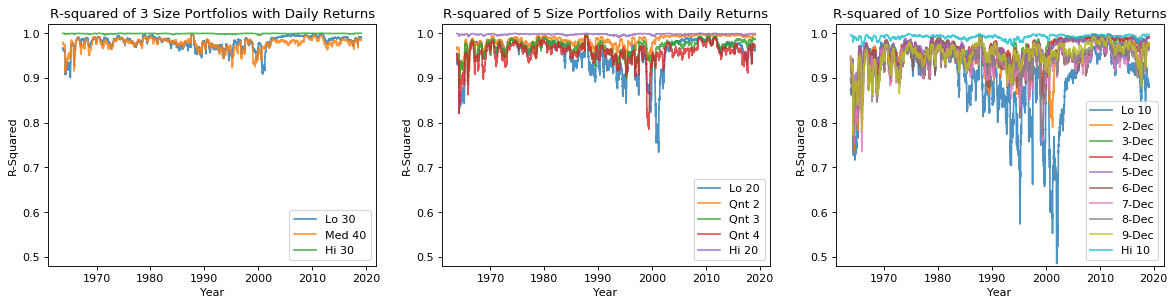

In [26]:
fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
plt.plot(Rsquare_3_pf['Portfoio0'],label="Lo 30",alpha=0.8)
plt.plot(Rsquare_3_pf['Portfoio1'],label="Med 40",alpha=0.8)
plt.plot(Rsquare_3_pf['Portfoio2'],label="Hi 30",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.title('R-squared of 3 Size Portfolios with Daily Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')

plt.subplot(1, 3, 2)
plt.plot(Rsquare_5_pf['Portfoio0'],label="Lo 20",alpha=0.8)
plt.plot(Rsquare_5_pf['Portfoio1'],label="Qnt 2",alpha=0.8)
plt.plot(Rsquare_5_pf['Portfoio2'],label="Qnt 3",alpha=0.8)
plt.plot(Rsquare_5_pf['Portfoio3'],label="Qnt 4",alpha=0.8)
plt.plot(Rsquare_5_pf['Portfoio4'],label="Hi 20",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.title('R-squared of 5 Size Portfolios with Daily Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')

plt.subplot(1, 3, 3)
plt.plot(Rsquare_10_pf['Portfoio0'],label="Lo 10",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio1'],label="2-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio2'],label="3-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio3'],label="4-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio4'],label="5-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio5'],label="6-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio6'],label="7-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio7'],label="8-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio8'],label="9-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio9'],label="Hi 10",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.title('R-squared of 10 Size Portfolios with Daily Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')

plt.show()


In [ ]:
####################  2. Regression with Monthly Return   ###################################

In [28]:
#pf_size_mm = pd.read_csv('C:/Users/yz2991/Desktop/Portfolios_Formed_on_ME_monthly.csv')
#ff5_mm = pd.read_csv('C:/Users/yz2991/Desktop/F-F_Research_Data_5_Factors_2x3_monthly.csv')

pf_size_mm = pd.read_csv('data/Portfolios_Formed_on_ME_monthly.csv')
ff5_mm = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3_monthly.csv')


In [29]:
print(pf_size_mm.tail())

     Unnamed: 0   <= 0  Lo 30  Med 40  Hi 30  Lo 20  Qnt 2  Qnt 3  Qnt 4  \
666      201901 -99.99  10.35   12.28   8.02  10.16  10.74  12.33  11.18   
667      201902 -99.99   5.82    5.68   3.30   5.93   5.46   5.29   4.84   
668      201903 -99.99  -2.50   -1.41   1.75  -2.82  -2.42  -1.53   0.50   
669      201904 -99.99   2.49    4.28   4.24   1.75   2.87   4.69   3.82   
670      201905 -99.99  -7.50   -8.27  -6.58  -7.15  -8.94  -7.48  -7.00   

     Hi 20  Lo 10  2-Dec  3-Dec  4-Dec  5-Dec  6-Dec  7-Dec  8-Dec  9-Dec  \
666   7.82  10.59   9.88  10.55  10.89  12.91  11.85  12.74  10.27  10.24   
667   3.24   5.33   6.33   5.71   5.26   4.63   5.84   6.29   3.99   5.16   
668   1.78  -2.98  -2.71  -2.16  -2.63  -2.31  -0.88  -0.82   1.30   0.49   
669   4.31   1.26   2.08   3.24   2.55   4.19   5.10   4.46   3.45   4.08   
670  -6.62  -6.47  -7.60  -7.86  -9.87  -8.10  -6.97  -8.58  -6.07  -6.16   

     Hi 10  
666   7.40  
667   2.89  
668   2.03  
669   4.35  
670  -6.70  


In [30]:
pf_size_mm.rename(columns = {'Unnamed: 0': 'YYMM'}, inplace = True)
ff5_mm.rename(columns = {'Unnamed: 0': 'YYMM'}, inplace = True)

In [31]:
pf_size_excess_mm=(pf_size_mm.iloc[:,1:pf_size_mm.shape[1]]).sub(ff5_mm.RF,axis=0)

In [32]:
ff5_mm['YYMM'] = pd.to_datetime(ff5_mm['YYMM'],yearfirst=True, format='%Y%m')
pf_size_excess_mm['YYMM'] = pd.to_datetime(pf_size_mm['YYMM'],yearfirst=True, format='%Y%m')

In [33]:
print(pf_size_excess_mm.tail())

       <= 0  Lo 30  Med 40  Hi 30  Lo 20  Qnt 2  Qnt 3  Qnt 4  Hi 20  Lo 10  \
666 -100.20  10.14   12.07   7.81   9.95  10.53  12.12  10.97   7.61  10.38   
667 -100.17   5.64    5.50   3.12   5.75   5.28   5.11   4.66   3.06   5.15   
668 -100.18  -2.69   -1.60   1.56  -3.01  -2.61  -1.72   0.31   1.59  -3.17   
669 -100.20   2.28    4.07   4.03   1.54   2.66   4.48   3.61   4.10   1.05   
670 -100.20  -7.71   -8.48  -6.79  -7.36  -9.15  -7.69  -7.21  -6.83  -6.68   

     2-Dec  3-Dec  4-Dec  5-Dec  6-Dec  7-Dec  8-Dec  9-Dec  Hi 10       YYMM  
666   9.67  10.34  10.68  12.70  11.64  12.53  10.06  10.03   7.19 2019-01-01  
667   6.15   5.53   5.08   4.45   5.66   6.11   3.81   4.98   2.71 2019-02-01  
668  -2.90  -2.35  -2.82  -2.50  -1.07  -1.01   1.11   0.30   1.84 2019-03-01  
669   1.87   3.03   2.34   3.98   4.89   4.25   3.24   3.87   4.14 2019-04-01  
670  -7.81  -8.07 -10.08  -8.31  -7.18  -8.79  -6.28  -6.37  -6.91 2019-05-01  


In [34]:
ff5_mm.index = ff5_mm['YYMM']
pf_size_excess_mm.index = pf_size_excess_mm['YYMM']
ff5_mm = ff5_mm.drop('YYMM', axis = 1)
ff5_mm = ff5_mm.drop('RF', axis = 1)

In [163]:
#use 10 year window (number of obs will be close to daily models with half-year window)
start_mm = ff5_mm.index[0]
end_mm = ff5_mm.index[ff5_mm.shape[0]-1]
n_month = end_mm - start_mm
print(ff5_mm.shape[0])
window_mm = 120
n_window_mm = ff5_mm.shape[0] - window_mm + 1
print(n_window_mm)
print(end_mm)

671
552
2019-05-01 00:00:00


In [164]:
print(window_mm)
window_nm_month = []
for i in range(n_window_mm):
    nm = ff5_mm.index[i+int(window_mm/2)]
    window_nm_month.append(nm)
print(len(window_nm_month))
portfolio_nm_3 = pf_size_excess.columns[1:4]
print(portfolio_nm_3)

120
552
Index(['Lo 30', 'Med 40', 'Hi 30'], dtype='object')


In [37]:
#To run OLS on a 120-month rolling window basis. The logic of this loop is to run the rolling window regressions \n",
#for each of the 3 portfolios. That is, the first 552 models are for the portfolio Lo 30,\n",
#the next 552 models are for the portfolio Med 40\n",
pf_3_mm = pf_size_excess_mm.loc[:,['Lo 30','Med 40','Hi 30']]
models_3_pf_mm = []
for i in range (3):
    for m in range(n_window_mm):
        
        t0 = ff5_mm.index[0+m]
        if ff5_mm.index[0+m+window_mm-1] < end_mm:
            t1 = ff5_mm.index[0+m+window_mm-1]
        else:
            t1 = end_mm
        
        x = ff5_mm[t0:t1]
        x = sm.add_constant(x)
        y = pf_3_mm[t0:t1]
        reg = sm.OLS(y.iloc[:,i], x)   
        models_3_pf_mm.append(reg.fit())
    

In [65]:
Rsquare_3_pf_mm = {}
for i in range(3):
    x = []
    for n in range(n_window_mm):  
        x.append(models_3_pf_mm[i*n_window_mm +n].rsquared) 
    Rsquare_3_pf_mm["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm_month)

In [66]:
#To run OLS on a 120-month rolling window basis. The logic of this loop is to run the rolling window regressions \n",
#for each of the 3 portfolios. That is, the first 552 models are for the portfolio Lo 30,\n",
#the next 552 models are for the portfolio Med 40\n",
pf_5_mm = pf_size_excess_mm.loc[:,['Lo 20', 'Qnt 2', 'Qnt 3', 'Qnt 4', 'Hi 20']]
models_5_pf_mm = []
for i in range (5):
    for m in range(n_window_mm):
        
        t0 = ff5_mm.index[0+m]
        if ff5_mm.index[0+m+window_mm-1] < end_mm:
            t1 = ff5_mm.index[0+m+window_mm-1]
        else:
            t1 = end_mm
        
        x = ff5_mm[t0:t1]
        x = sm.add_constant(x)
        y = pf_5_mm[t0:t1]
        reg = sm.OLS(y.iloc[:,i], x)   
        models_5_pf_mm.append(reg.fit())

In [67]:
Rsquare_5_pf_mm = {}
for i in range(5):
    x = []
    for n in range(n_window_mm):  
        x.append(models_5_pf_mm[i*n_window_mm +n].rsquared) 
    Rsquare_5_pf_mm["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm_month)

In [68]:
#To run OLS on a 120-month rolling window basis. The logic of this loop is to run the rolling window regressions \n",
#for each of the 3 portfolios. That is, the first 552 models are for the portfolio Lo 30,\n",
#the next 552 models are for the portfolio Med 40\n",
pf_10_mm = pf_size_excess_mm.loc[:,['Lo 10', '2-Dec', '3-Dec','4-Dec', '5-Dec', '6-Dec', '7-Dec', '8-Dec','9-Dec', 'Hi 10']]
models_10_pf_mm = []
for i in range (10):
    for m in range(n_window_mm):
        
        t0 = ff5_mm.index[0+m]
        if ff5_mm.index[0+m+window_mm-1] < end_mm:
            t1 = ff5_mm.index[0+m+window_mm-1]
        else:
            t1 = end_mm
        
        x = ff5_mm[t0:t1]
        x = sm.add_constant(x)
        y = pf_10_mm[t0:t1]
        reg = sm.OLS(y.iloc[:,i], x)   
        models_10_pf_mm.append(reg.fit())

In [69]:
Rsquare_10_pf_mm = {}
for i in range(10):
    x = []
    for n in range(n_window_mm):  
        x.append(models_10_pf_mm[i*n_window_mm +n].rsquared) 
    Rsquare_10_pf_mm["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm_month)

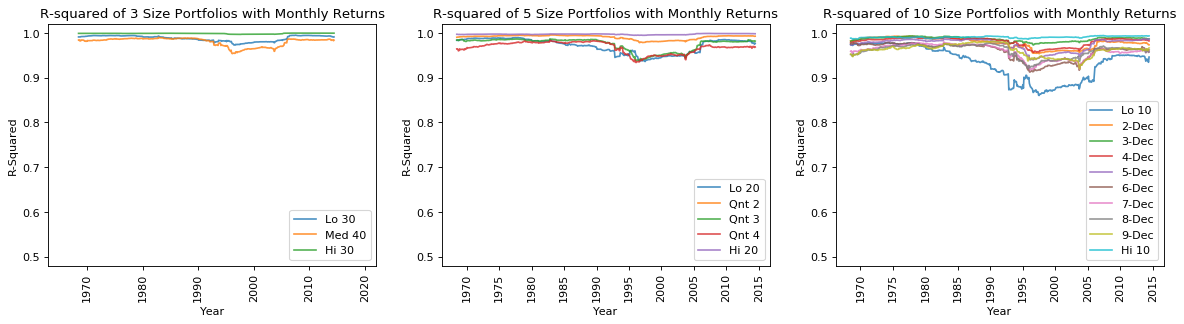

In [70]:
fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
plt.plot(Rsquare_3_pf_mm['Portfoio0'],label="Lo 30",alpha=0.8)
plt.plot(Rsquare_3_pf_mm['Portfoio1'],label="Med 40",alpha=0.8)
plt.plot(Rsquare_3_pf_mm['Portfoio2'],label="Hi 30",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.xlim(["1963","2022"])
plt.title('R-squared of 3 Size Portfolios with Monthly Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
plt.plot(Rsquare_5_pf_mm['Portfoio0'],label="Lo 20",alpha=0.8)
plt.plot(Rsquare_5_pf_mm['Portfoio1'],label="Qnt 2",alpha=0.8)
plt.plot(Rsquare_5_pf_mm['Portfoio2'],label="Qnt 3",alpha=0.8)
plt.plot(Rsquare_5_pf_mm['Portfoio3'],label="Qnt 4",alpha=0.8)
plt.plot(Rsquare_5_pf_mm['Portfoio4'],label="Hi 20",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.title('R-squared of 5 Size Portfolios with Monthly Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
plt.plot(Rsquare_10_pf_mm['Portfoio0'],label="Lo 10",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio1'],label="2-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio2'],label="3-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio3'],label="4-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio4'],label="5-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio5'],label="6-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio6'],label="7-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio7'],label="8-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio8'],label="9-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio9'],label="Hi 10",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.title('R-squared of 10 Size Portfolios with Monthly Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')
plt.xticks(rotation=90)

plt.show()

<Figure size 5400x5400 with 0 Axes>

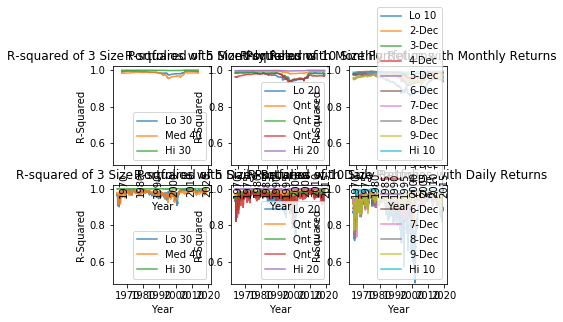

In [84]:
plt.figure(figsize=(30, 30), dpi= 180, facecolor='w', edgecolor='k')
#plt.figure(figsize=(20,10))
plt.subplots(2, 3, sharex=True, sharey=True)

plt.subplot(2, 3, 4)
plt.plot(Rsquare_3_pf['Portfoio0'],label="Lo 30",alpha=0.8)
plt.plot(Rsquare_3_pf['Portfoio1'],label="Med 40",alpha=0.8)
plt.plot(Rsquare_3_pf['Portfoio2'],label="Hi 30",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.title('R-squared of 3 Size Portfolios with Daily Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')

plt.subplot(2, 3, 5)
plt.plot(Rsquare_5_pf['Portfoio0'],label="Lo 20",alpha=0.8)
plt.plot(Rsquare_5_pf['Portfoio1'],label="Qnt 2",alpha=0.8)
plt.plot(Rsquare_5_pf['Portfoio2'],label="Qnt 3",alpha=0.8)
plt.plot(Rsquare_5_pf['Portfoio3'],label="Qnt 4",alpha=0.8)
plt.plot(Rsquare_5_pf['Portfoio4'],label="Hi 20",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.title('R-squared of 5 Size Portfolios with Daily Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')

plt.subplot(2, 3, 6)
plt.plot(Rsquare_10_pf['Portfoio0'],label="Lo 10",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio1'],label="2-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio2'],label="3-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio3'],label="4-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio4'],label="5-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio5'],label="6-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio6'],label="7-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio7'],label="8-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio8'],label="9-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf['Portfoio9'],label="Hi 10",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.title('R-squared of 10 Size Portfolios with Daily Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')

plt.subplot(2, 3, 1)
plt.plot(Rsquare_3_pf_mm['Portfoio0'],label="Lo 30",alpha=0.8)
plt.plot(Rsquare_3_pf_mm['Portfoio1'],label="Med 40",alpha=0.8)
plt.plot(Rsquare_3_pf_mm['Portfoio2'],label="Hi 30",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.xlim(["1963","2022"])
plt.title('R-squared of 3 Size Portfolios with Monthly Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')
plt.xticks(rotation=90)

plt.subplot(2, 3, 2)
plt.plot(Rsquare_5_pf_mm['Portfoio0'],label="Lo 20",alpha=0.8)
plt.plot(Rsquare_5_pf_mm['Portfoio1'],label="Qnt 2",alpha=0.8)
plt.plot(Rsquare_5_pf_mm['Portfoio2'],label="Qnt 3",alpha=0.8)
plt.plot(Rsquare_5_pf_mm['Portfoio3'],label="Qnt 4",alpha=0.8)
plt.plot(Rsquare_5_pf_mm['Portfoio4'],label="Hi 20",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.title('R-squared of 5 Size Portfolios with Monthly Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')
plt.xticks(rotation=90)

plt.subplot(2, 3, 3)
plt.plot(Rsquare_10_pf_mm['Portfoio0'],label="Lo 10",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio1'],label="2-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio2'],label="3-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio3'],label="4-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio4'],label="5-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio5'],label="6-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio6'],label="7-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio7'],label="8-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio8'],label="9-Dec",alpha=0.8)
plt.plot(Rsquare_10_pf_mm['Portfoio9'],label="Hi 10",alpha=0.8)
plt.legend(loc='lower right')
plt.ylim([0.48,1.02])
plt.title('R-squared of 10 Size Portfolios with Monthly Returns')
plt.xlabel('Year')
plt.ylabel('R-Squared')
plt.xticks(rotation=90)

plt.show()

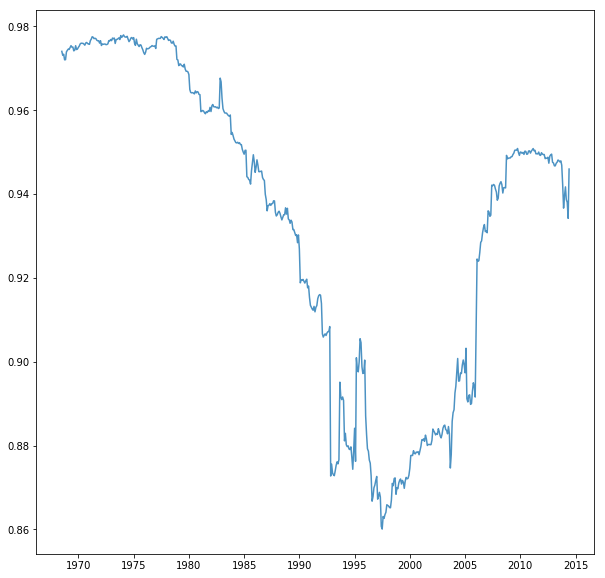

In [85]:
plt.figure(figsize=(10,10))
plt.plot(Rsquare_10_pf_mm['Portfoio0'],label="Lo 10",alpha=0.8)
plt.show()

In [45]:
####################  3. Factor Correlations with Monthly Return   ###################################

In [46]:
corr = ff5_mm.corr()

In [47]:
print(corr)

          Mkt-RF       SMB       HML       RMW       CMA
Mkt-RF  1.000000  0.276618 -0.254758 -0.228337 -0.386550
SMB     0.276618  1.000000 -0.068078 -0.347595 -0.105261
HML    -0.254758 -0.068078  1.000000  0.061226  0.692952
RMW    -0.228337 -0.347595  0.061226  1.000000 -0.037308
CMA    -0.386550 -0.105261  0.692952 -0.037308  1.000000


In [48]:
corr.iloc[1][4]

Rsquare_5_pf_mm = {}
for i in range(5):
    x = []
    for n in range(n_window_mm):  
        x.append(models_5_pf_mm[i*n_window_mm +n].rsquared) 
    Rsquare_5_pf_mm["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm_month)

In [49]:
correlation = []
for m in range(n_window_mm):
    t0 = ff5_mm.index[0+m]
    if ff5_mm.index[0+m+window_mm-1] < end_mm:
        t1 = ff5_mm.index[0+m+window_mm-1]
    else:
        t1 = end_mm
    correlation.append(ff5_mm[t0:t1].corr())        

In [50]:
print(correlation[1])
correlation[0].iloc[4][1]

          Mkt-RF       SMB       HML       RMW       CMA
Mkt-RF  1.000000  0.522292 -0.164799 -0.029840 -0.363053
SMB     0.522292  1.000000 -0.209512 -0.144585 -0.363920
HML    -0.164799 -0.209512  1.000000 -0.649084  0.771785
RMW    -0.029840 -0.144585 -0.649084  1.000000 -0.615301
CMA    -0.363053 -0.363920  0.771785 -0.615301  1.000000


-0.34243811368283755

In [51]:
Mrk_SMB = []
Mrk_HML = []
Mrk_RMW = []
Mrk_CMA = []
SMB_HML = []
SMB_RMW = []
SMB_CMA = []
HML_RMW = []
HML_CMA = []
RMW_CMA = []
for i in range(len(correlation)):
    Mrk_SMB.append(correlation[i].iloc[0][1])
    Mrk_HML.append(correlation[i].iloc[0][2])
    Mrk_RMW.append(correlation[i].iloc[0][3])
    Mrk_CMA.append(correlation[i].iloc[0][4])
    SMB_HML.append(correlation[i].iloc[1][2])
    SMB_RMW.append(correlation[i].iloc[1][3])
    SMB_CMA.append(correlation[i].iloc[1][4])
    HML_RMW.append(correlation[i].iloc[2][3])
    HML_CMA.append(correlation[i].iloc[2][4])
    RMW_CMA.append(correlation[i].iloc[3][4])
    
Mrk_SMB_Corr = pd.Series(Mrk_SMB,index = window_nm_month)
Mrk_HML_Corr = pd.Series(Mrk_HML,index = window_nm_month)  
Mrk_RMW_Corr = pd.Series(Mrk_RMW,index = window_nm_month)  
Mrk_CMA_Corr = pd.Series(Mrk_CMA,index = window_nm_month)  
SMB_HML_Corr = pd.Series(SMB_HML,index = window_nm_month)  
SMB_RMW_Corr = pd.Series(SMB_RMW,index = window_nm_month)  
SMB_CMA_Corr = pd.Series(SMB_CMA,index = window_nm_month)  
HML_RMW_Corr = pd.Series(HML_RMW,index = window_nm_month)  
HML_CMA_Corr = pd.Series(HML_CMA,index = window_nm_month)  
RMW_CMA_Corr = pd.Series(RMW_CMA,index = window_nm_month)  

In [90]:
plt.figure(figsize=(130, 180), dpi= 800, facecolor='w', edgecolor='k')
plt.subplots(4, 4, sharex=True, sharey=True)

plt.subplot(4, 4, 1)
plt.plot(Mrk_SMB_Corr)
plt.title('SMB')
plt.ylabel('Mrk-Rf')

plt.subplot(4, 4, 2)
plt.plot(Mrk_HML_Corr)
plt.title('HML')

plt.subplot(4, 4, 3)
plt.plot(Mrk_RMW_Corr)
plt.title('RMW')

plt.subplot(4, 4, 4)
plt.plot(Mrk_CMA_Corr)
plt.title('CMA')

plt.subplot(4, 4, 6)
plt.plot(SMB_HML_Corr)
plt.ylabel('SMB')

plt.subplot(4, 4, 7)
plt.plot(SMB_RMW_Corr)


plt.subplot(4, 4, 8)
plt.plot(SMB_CMA_Corr)


plt.subplot(4, 4, 11)
plt.plot(HML_RMW_Corr)
plt.ylabel('RMW')

plt.subplot(4, 4, 12)
plt.plot(HML_CMA_Corr)

plt.subplot(4, 4, 16)
plt.plot(RMW_CMA_Corr)
plt.ylabel('CMA')

plt.show()

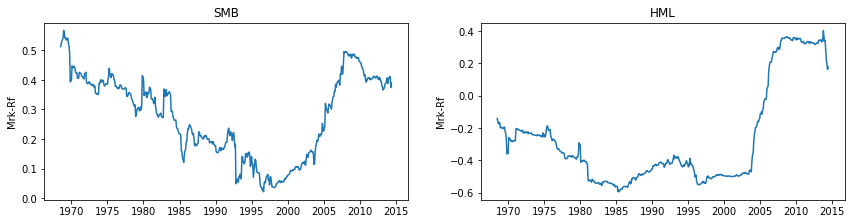

In [121]:
fig1 = plt.figure(figsize=(30, 15))

ax1 = fig1.add_subplot(441)
ax1.plot(Mrk_SMB_Corr)
ax1.set_title('SMB')
ax1.set_ylabel('Mrk-Rf')

ax2 = fig1.add_subplot(442)
ax2.plot(Mrk_HML_Corr)
ax2.set_title('HML')
ax2.set_ylabel('Mrk-Rf')



plt.show()

In [103]:
ax1.plot(Mrk_SMB_Corr)
plt.show()

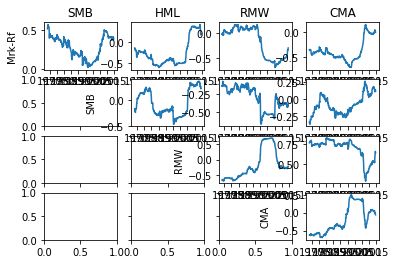

In [104]:
plt.subplots(4, 4, sharex=True, sharey=True)

plt.subplot(4, 4, 1)
plt.plot(Mrk_SMB_Corr)
plt.title('SMB')
plt.ylabel('Mrk-Rf')

plt.subplot(4, 4, 2)
plt.plot(Mrk_HML_Corr)
plt.title('HML')

plt.subplot(4, 4, 3)
plt.plot(Mrk_RMW_Corr)
plt.title('RMW')

plt.subplot(4, 4, 4)
plt.plot(Mrk_CMA_Corr)
plt.title('CMA')

plt.subplot(4, 4, 6)
plt.plot(SMB_HML_Corr)
plt.ylabel('SMB')

plt.subplot(4, 4, 7)
plt.plot(SMB_RMW_Corr)


plt.subplot(4, 4, 8)
plt.plot(SMB_CMA_Corr)


plt.subplot(4, 4, 11)
plt.plot(HML_RMW_Corr)
plt.ylabel('RMW')

plt.subplot(4, 4, 12)
plt.plot(HML_CMA_Corr)

plt.subplot(4, 4, 16)
plt.plot(RMW_CMA_Corr)
plt.ylabel('CMA')

plt.show()

In [53]:
####################  4. Factor Significance in Daily Return ###################################

In [54]:

lo_30_p = {}
Med_40_p = {}
Hi_30_p = {}

factor = ['Const', 'Mrk-Rf', 'SMB', 'HML', 'RMW', 'CMA']

for j in range(6):
    x= []
    for i in range(int(len(models_3_pf)/3)):            
        x.append(models_3_pf[i].pvalues[j])
    lo_30_p[factor[j]] = pd.Series(x, index = window_nm)

for j in range(6):
    x= []
    for i in range(int(len(models_3_pf)/3)-1, 2*int(len(models_3_pf)/3)-1):            
        x.append(models_3_pf[i].pvalues[j])
    Med_40_p[factor[j]] = pd.Series(x, index=window_nm)
    
for j in range(6):
    x= []
    for i in range(2*int(len(models_3_pf)/3)-1, len(models_3_pf)-1):            
        x.append(models_3_pf[i].pvalues[j])
    Hi_30_p[factor[j]] = pd.Series(x, index = window_nm)

lo_30_p_summary = pd.concat([lo_30_p[factor[1]],lo_30_p[factor[2]],lo_30_p[factor[3]],lo_30_p[factor[4]],lo_30_p[factor[5]]], axis=1)
Med_40_p_summary = pd.concat([Med_40_p[factor[1]],Med_40_p[factor[2]],Med_40_p[factor[3]],Med_40_p[factor[4]],Med_40_p[factor[5]]], axis=1)
Hi_30_p_summary = pd.concat([Hi_30_p[factor[1]],Hi_30_p[factor[2]],Hi_30_p[factor[3]],Hi_30_p[factor[4]],Hi_30_p[factor[5]]], axis=1)


In [55]:
lo_30_p_summary['Mrk-Rf Ind'] = [1 if x < 0.05 else 0 for x in lo_30_p_summary[0]]
lo_30_p_summary['SMB Ind'] = [1 if x < 0.05 else 0 for x in lo_30_p_summary[1]]
lo_30_p_summary['HML Ind'] = [1 if x < 0.05 else 0 for x in lo_30_p_summary[2]]
lo_30_p_summary['RMW Ind'] = [1 if x < 0.05 else 0 for x in lo_30_p_summary[3]]
lo_30_p_summary['CMA Ind'] = [1 if x < 0.05 else 0 for x in lo_30_p_summary[4]]

Med_40_p_summary['Mrk-Rf Ind'] = [1 if x < 0.05 else 0 for x in Med_40_p_summary[0]]
Med_40_p_summary['SMB Ind'] = [1 if x < 0.05 else 0 for x in Med_40_p_summary[1]]
Med_40_p_summary['HML Ind'] = [1 if x < 0.05 else 0 for x in Med_40_p_summary[2]]
Med_40_p_summary['RMW Ind'] = [1 if x < 0.05 else 0 for x in Med_40_p_summary[3]]
Med_40_p_summary['CMA Ind'] = [1 if x < 0.05 else 0 for x in Med_40_p_summary[4]]

Hi_30_p_summary['Mrk-Rf Ind'] = [1 if x < 0.05 else 0 for x in Hi_30_p_summary[0]]
Hi_30_p_summary['SMB Ind'] = [1 if x < 0.05 else 0 for x in Hi_30_p_summary[1]]
Hi_30_p_summary['HML Ind'] = [1 if x < 0.05 else 0 for x in Hi_30_p_summary[2]]
Hi_30_p_summary['RMW Ind'] = [1 if x < 0.05 else 0 for x in Hi_30_p_summary[3]]
Hi_30_p_summary['CMA Ind'] = [1 if x < 0.05 else 0 for x in Hi_30_p_summary[4]]


<Figure size 1440x480 with 0 Axes>

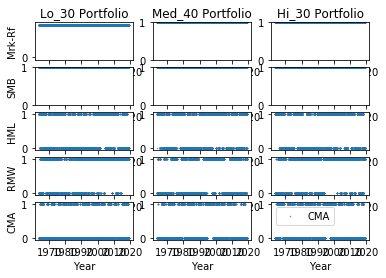

In [56]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots(5, 3, sharex=True, sharey=True)

plt.subplot(5, 3, 1)
plt.plot(lo_30_p_summary['Mrk-Rf Ind'],'o',markersize = 0.5,label="Mrk",alpha=0.8)
plt.title('Lo_30 Portfolio')
plt.ylabel('Mrk-Rf')
plt.ylim([-0.1,1.1])
plt.yticks(np.arange(0, 1, step=1))

plt.subplot(5, 3, 2)
plt.plot(Med_40_p_summary['Mrk-Rf Ind'],'o',markersize = 0.5, label="Mrk",alpha=0.8)
plt.title('Med_40 Portfolio')
plt.ylim([0,1])
plt.subplot(5, 3, 3)
plt.plot(Hi_30_p_summary['Mrk-Rf Ind'],'o',markersize = 0.5, label="Mrk",alpha=0.8)
plt.title('Hi_30 Portfolio')
plt.ylim([0,1])

plt.subplot(5, 3, 4)
plt.plot(lo_30_p_summary['SMB Ind'],'o',markersize = 0.5,label="SMB",alpha=0.8)
plt.ylabel('SMB')
plt.ylim([0,1])
plt.subplot(5, 3, 5)
plt.plot(Med_40_p_summary['SMB Ind'],'o',markersize = 0.5, label="SMB",alpha=0.8)
plt.ylim([0,1])
plt.subplot(5, 3, 6)
plt.plot(Hi_30_p_summary['SMB Ind'],'o',markersize = 0.5, label="SMB",alpha=0.8)
plt.ylim([0,1])

plt.subplot(5, 3, 7)
plt.plot(lo_30_p_summary['HML Ind'],'o',markersize = 0.5,label="HML",alpha=0.8)
plt.ylabel('HML')
plt.subplot(5, 3, 8)
plt.plot(Med_40_p_summary['HML Ind'],'o',markersize = 0.5, label="HML",alpha=0.8)
plt.subplot(5, 3, 9)
plt.plot(Hi_30_p_summary['HML Ind'],'o',markersize = 0.5, label="HML",alpha=0.8)

plt.subplot(5, 3, 10)
plt.plot(lo_30_p_summary['RMW Ind'],'o',markersize = 0.5,label="RMW",alpha=0.8)
plt.ylabel('RMW')
plt.subplot(5, 3, 11)
plt.plot(Med_40_p_summary['RMW Ind'],'o',markersize = 0.5, label="RMW",alpha=0.8)
plt.subplot(5, 3, 12)
plt.plot(Hi_30_p_summary['RMW Ind'],'o',markersize = 0.5, label="RMW",alpha=0.8)

plt.subplot(5, 3, 13)
plt.plot(lo_30_p_summary['CMA Ind'],'o',markersize = 0.5,label="CMA",alpha=0.8)
plt.ylabel('CMA')
plt.xlabel('Year')
plt.subplot(5, 3, 14)
plt.plot(Med_40_p_summary['CMA Ind'],'o',markersize = 0.5, label="CMA",alpha=0.8)
plt.xlabel('Year')
plt.subplot(5, 3, 15)
plt.plot(Hi_30_p_summary['CMA Ind'],'o',markersize = 0.5, label="CMA",alpha=0.8)
plt.xlabel('Year')


plt.legend(loc='upper left')
plt.show()

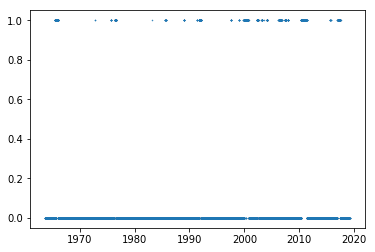

0.08458781362007169

In [57]:
#when all 5 factors are significant
all_sign_lo30 = lo_30_p_summary.iloc[:,5:10].product(axis = 1)
plt.plot(all_sign_lo30,'o',markersize = 0.5) 
plt.show()
all_sign_lo30.sum(axis=0)/len(all_sign_lo30)

In [58]:
signperc_lo30 = lo_30_p_summary.iloc[:,5:10].sum(axis = 0)/len(lo_30_p_summary)
signperc_Med40 = Med_40_p_summary.iloc[:,5:10].sum(axis = 0)/len(Med_40_p_summary)
signperc_Hi30 = Hi_30_p_summary.iloc[:,5:10].sum(axis = 0)/len(Hi_30_p_summary)

In [59]:
signperc_summary = pd.concat([signperc_lo30,signperc_Med40,signperc_Hi30], axis=1)
signperc_summary.columns = ['Lo 30', 'Med 40', 'Hi 30']

In [60]:
print(signperc_lo30)
print(signperc_Med40)
print(signperc_Hi30)
print(signperc_summary)

Mrk-Rf Ind    1.000000
SMB Ind       1.000000
HML Ind       0.426738
RMW Ind       0.671828
CMA Ind       0.252832
dtype: float64
Mrk-Rf Ind    1.000000
SMB Ind       1.000000
HML Ind       0.526237
RMW Ind       0.398351
CMA Ind       0.296201
dtype: float64
Mrk-Rf Ind    1.000000
SMB Ind       1.000000
HML Ind       0.518136
RMW Ind       0.635842
CMA Ind       0.345018
dtype: float64
               Lo 30    Med 40     Hi 30
Mrk-Rf Ind  1.000000  1.000000  1.000000
SMB Ind     1.000000  1.000000  1.000000
HML Ind     0.426738  0.526237  0.518136
RMW Ind     0.671828  0.398351  0.635842
CMA Ind     0.252832  0.296201  0.345018


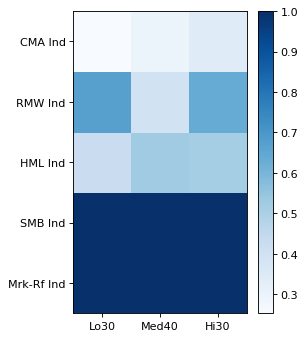

In [61]:
plt.close()
fig=plt.figure(figsize=(3.5, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.pcolor(signperc_summary, cmap=plt.cm.Blues)
plt.yticks(np.arange(0.5, len(signperc_lo30), 1), signperc_lo30.index)
plt.xticks(np.arange(0.5, 3, 1), ['Lo30', 'Med40', 'Hi30'])
plt.colorbar()
plt.show()

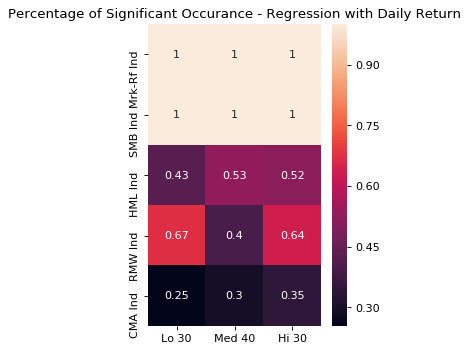

In [62]:
plt.close()
plt.figure(figsize=(3.5, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(signperc_summary,annot=True)
plt.title('Percentage of Significant Occurance - Regression with Daily Return')
plt.show()

In [63]:
####################  5. Factor Significance in Daily Monthly Regressions   ###################################

In [64]:
lo_30_p_mm = {}
Med_40_p_mm = {}
Hi_30_p_mm = {}

factor = ['Const', 'Mrk-Rf', 'SMB', 'HML', 'RMW', 'CMA']

for j in range(6):
    x= []
    for i in range(int(len(models_3_pf_mm)/3)):            
        x.append(models_3_pf_mm[i].pvalues[j])
    lo_30_p_mm[factor[j]] = pd.Series(x, index = window_nm_month)

for j in range(6):
    x= []
    for i in range(int(len(models_3_pf_mm)/3)-1, 2*int(len(models_3_pf_mm)/3)-1):            
        x.append(models_3_pf_mm[i].pvalues[j])
    Med_40_p_mm[factor[j]] = pd.Series(x, index=window_nm_month)
    
for j in range(6):
    x= []
    for i in range(2*int(len(models_3_pf_mm)/3)-1, len(models_3_pf_mm)-1):            
        x.append(models_3_pf_mm[i].pvalues[j])
    Hi_30_p_mm[factor[j]] = pd.Series(x, index = window_nm_month)

lo_30_p_mm_summary = pd.concat([lo_30_p_mm[factor[1]],lo_30_p_mm[factor[2]],lo_30_p_mm[factor[3]],lo_30_p_mm[factor[4]],lo_30_p_mm[factor[5]]], axis=1)
Med_40_p_mm_summary = pd.concat([Med_40_p_mm[factor[1]],Med_40_p_mm[factor[2]],Med_40_p_mm[factor[3]],Med_40_p_mm[factor[4]],Med_40_p_mm[factor[5]]], axis=1)
Hi_30_p_mm_summary = pd.concat([Hi_30_p_mm[factor[1]],Hi_30_p_mm[factor[2]],Hi_30_p_mm[factor[3]],Hi_30_p_mm[factor[4]],Hi_30_p_mm[factor[5]]], axis=1)


In [ ]:
lo_30_p_mm_summary['Mrk-Rf Ind'] = [1 if x < 0.05 else 0 for x in lo_30_p_mm_summary[0]]
lo_30_p_mm_summary['SMB Ind'] = [1 if x < 0.05 else 0 for x in lo_30_p_mm_summary[1]]
lo_30_p_mm_summary['HML Ind'] = [1 if x < 0.05 else 0 for x in lo_30_p_mm_summary[2]]
lo_30_p_mm_summary['RMW Ind'] = [1 if x < 0.05 else 0 for x in lo_30_p_mm_summary[3]]
lo_30_p_mm_summary['CMA Ind'] = [1 if x < 0.05 else 0 for x in lo_30_p_mm_summary[4]]

Med_40_p_mm_summary['Mrk-Rf Ind'] = [1 if x < 0.05 else 0 for x in Med_40_p_mm_summary[0]]
Med_40_p_mm_summary['SMB Ind'] = [1 if x < 0.05 else 0 for x in Med_40_p_mm_summary[1]]
Med_40_p_mm_summary['HML Ind'] = [1 if x < 0.05 else 0 for x in Med_40_p_mm_summary[2]]
Med_40_p_mm_summary['RMW Ind'] = [1 if x < 0.05 else 0 for x in Med_40_p_mm_summary[3]]
Med_40_p_mm_summary['CMA Ind'] = [1 if x < 0.05 else 0 for x in Med_40_p_mm_summary[4]]

Hi_30_p_mm_summary['Mrk-Rf Ind'] = [1 if x < 0.05 else 0 for x in Hi_30_p_mm_summary[0]]
Hi_30_p_mm_summary['SMB Ind'] = [1 if x < 0.05 else 0 for x in Hi_30_p_mm_summary[1]]
Hi_30_p_mm_summary['HML Ind'] = [1 if x < 0.05 else 0 for x in Hi_30_p_mm_summary[2]]
Hi_30_p_mm_summary['RMW Ind'] = [1 if x < 0.05 else 0 for x in Hi_30_p_mm_summary[3]]
Hi_30_p_mm_summary['CMA Ind'] = [1 if x < 0.05 else 0 for x in Hi_30_p_mm_summary[4]]


In [ ]:
signperc_lo30_mm = lo_30_p_mm_summary.iloc[:,5:10].sum(axis = 0)/len(lo_30_p_mm_summary)
signperc_Med40_mm = Med_40_p_mm_summary.iloc[:,5:10].sum(axis = 0)/len(Med_40_p_mm_summary)
signperc_Hi30_mm = Hi_30_p_mm_summary.iloc[:,5:10].sum(axis = 0)/len(Hi_30_p_mm_summary)

In [ ]:
signperc_mm_summary = pd.concat([signperc_lo30_mm,signperc_Med40_mm,signperc_Hi30_mm], axis=1)
signperc_mm_summary.columns = ['Lo 30', 'Med 40', 'Hi 30']

In [ ]:
plt.close()
plt.figure(figsize=(3.5, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(signperc_mm_summary,annot=True)
plt.title('Percentage of Significant Occurance - Regression with Monthly Return')
plt.show()